# Bigrams - MakeMore pt.1 (12/04/2023)

We now move on to see some interesting applications of the theory we developed earlier on. 

Mostly, we will see how to construct a language model, character based, able to 'learn' how to 'reproduce' $\mu(x_n|x_1, \dots, x_{n-1})$. 
We will develop such model following "chronological" steps, in the sense that we'll start from an older programming structure and later improve the latest feature in Artificial Intelligence.

Almost all the material presented is taken from [A. Karpathy's course](https://youtu.be/PaCmpygFfXo) and [GitHub repository](https://github.com/karpathy/makemore).

First, we start with *counting approach* (not to be confused with the counting technique earlier presented) to implement a bigram approximation of our "language" model (a "$2$-Markov" approximation).

We want to learn something from a dataset of words.
First of all, we need a machine which generates these data (the so-called words).

In [22]:
words = open('data/nomi_italiani.txt').read().splitlines()

Let's figure out the length of each word in our dataset.

In [23]:
L = [len(w) for w in words]
print(words[L.index(max(L))])

marie-odette-rose-gabrielle


In [24]:
import numpy as np

print(np.mean(L))

7.088193300384404


In [25]:
import random
random.seed(154)
random.shuffle(words)
print(words[:10])

['castorino', 'ella', 'irmo', 'leoluca', 'sankhare', 'galvano', 'faleria', 'germando', 'illo', 'romilde']


In [26]:
for w in words[:1]:
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

c a
a s
s t
t o
o r
r i
i n
n o


In [27]:
print(w)
list(w)
print(w[1:])

castorino
astorino


To get all bigrams of, for example, the last three words one can do something like that

In [28]:
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)

<S> c
c a
a s
s t
t o
o r
r i
i n
n o
o <E>
<S> e
e l
l l
l a
a <E>
<S> i
i r
r m
m o
o <E>


How many often does a bigram happen?

In [29]:
b = {}
for w in words[:3]:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        b[(ch1, ch2)] = b.get((ch1, ch2), 0) + 1
print(b)

{('<S>', 'c'): 1, ('c', 'a'): 1, ('a', 's'): 1, ('s', 't'): 1, ('t', 'o'): 1, ('o', 'r'): 1, ('r', 'i'): 1, ('i', 'n'): 1, ('n', 'o'): 1, ('o', '<E>'): 2, ('<S>', 'e'): 1, ('e', 'l'): 1, ('l', 'l'): 1, ('l', 'a'): 1, ('a', '<E>'): 1, ('<S>', 'i'): 1, ('i', 'r'): 1, ('r', 'm'): 1, ('m', 'o'): 1}


We can do it for all words

In [30]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        b[(ch1, ch2)] = b.get((ch1, ch2), 0) + 1

We now want to construct a machine which tells us the probability of the next character.
Let's sort all by frequency

In [31]:
print(sorted(b.items(), key=lambda z: -z[1]))

[(('o', '<E>'), 4235), (('a', '<E>'), 3831), (('i', 'n'), 1935), (('a', 'n'), 1497), (('r', 'i'), 1483), (('n', 'a'), 1429), (('i', 'o'), 1380), (('i', 'a'), 1344), (('n', 'o'), 1269), (('l', 'i'), 1261), (('e', 'r'), 1149), (('<S>', 'a'), 1095), (('e', 'l'), 1070), (('a', 'r'), 957), (('o', 'r'), 920), (('<S>', 'f'), 885), (('a', 'l'), 856), (('<S>', 'o'), 789), (('d', 'o'), 754), (('i', 'l'), 712), (('r', 'o'), 705), (('e', 'n'), 699), (('r', 'a'), 686), (('l', 'a'), 682), (('m', 'a'), 663), (('<S>', 'g'), 657), (('n', 'i'), 649), (('e', '<E>'), 630), (('<S>', 'e'), 629), (('<S>', 'r'), 626), (('<S>', 'm'), 595), (('o', 'n'), 591), (('r', 'e'), 584), (('t', 'a'), 580), (('d', 'a'), 565), (('t', 'o'), 559), (('d', 'i'), 552), (('o', 'l'), 545), (('d', 'e'), 540), (('l', 'l'), 537), (('m', 'i'), 532), (('s', 'i'), 531), (('<S>', 'c'), 520), (('l', 'e'), 511), (('g', 'i'), 496), (('i', 's'), 482), (('l', 'o'), 474), (('<S>', 'l'), 446), (('n', 'e'), 437), (('n', 'd'), 433), (('t', 'i'),

With the set function built-in python one can get the unique elements of a list

In [32]:
w = set(list(words[1]))
print(w)

{'e', 'a', 'l'}


Now we want to code this information
Let's take only the unique elements of a word, then of all words, i.e. our finite alphabet

In [33]:
chars = sorted(list(set(''.join(words))))
chars.append('<S>')
chars.append('<E>')
print(chars)

['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<S>', '<E>']


At this point we should have 27 characters, 26 letters of the alphabet and the dash from composite names

In [34]:
print(len(chars))

29


Actually we need 29 characters, i.e. the 27 previously discussed plus the initial and final of a word

In [35]:
import torch

N = torch.zeros(29, 29)

Let's now build an encoder, which assigns an integer value to each character of our alphabet.
This will be a dictionary. 

In [36]:
stoi = {s: i for i, s in enumerate(chars)}
stoi['<S>'] = 27
stoi['<E>'] = 28
print(stoi)

{'-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '<S>': 27, '<E>': 28}


Now let's count the frequency of each bigram and put it in our tensor.

In [37]:
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1
N[28, 27] = 1  # <E> <S>

<Axes: >

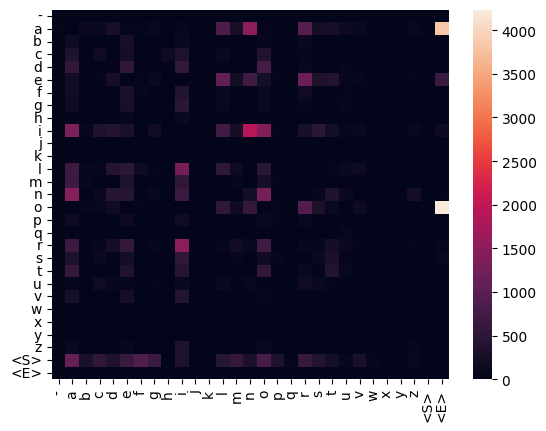

In [38]:
import seaborn as sns
sns.heatmap(N, xticklabels=chars, yticklabels=chars)

Now one can also build a decoder

In [39]:
itos = {i: s for s, i in stoi.items()}
print(itos)

{0: '-', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '<S>', 28: '<E>'}


Notice that **stoi** is associating to any character a number, so they are enumerated from $0$ to $26$ (the dimension of our alphabet is $29$).
On the other hand, **itos** is decoding a number into a character.

For a better visualization we can plot the whole matrix together with the bigrams and their frequencies

<Axes: >

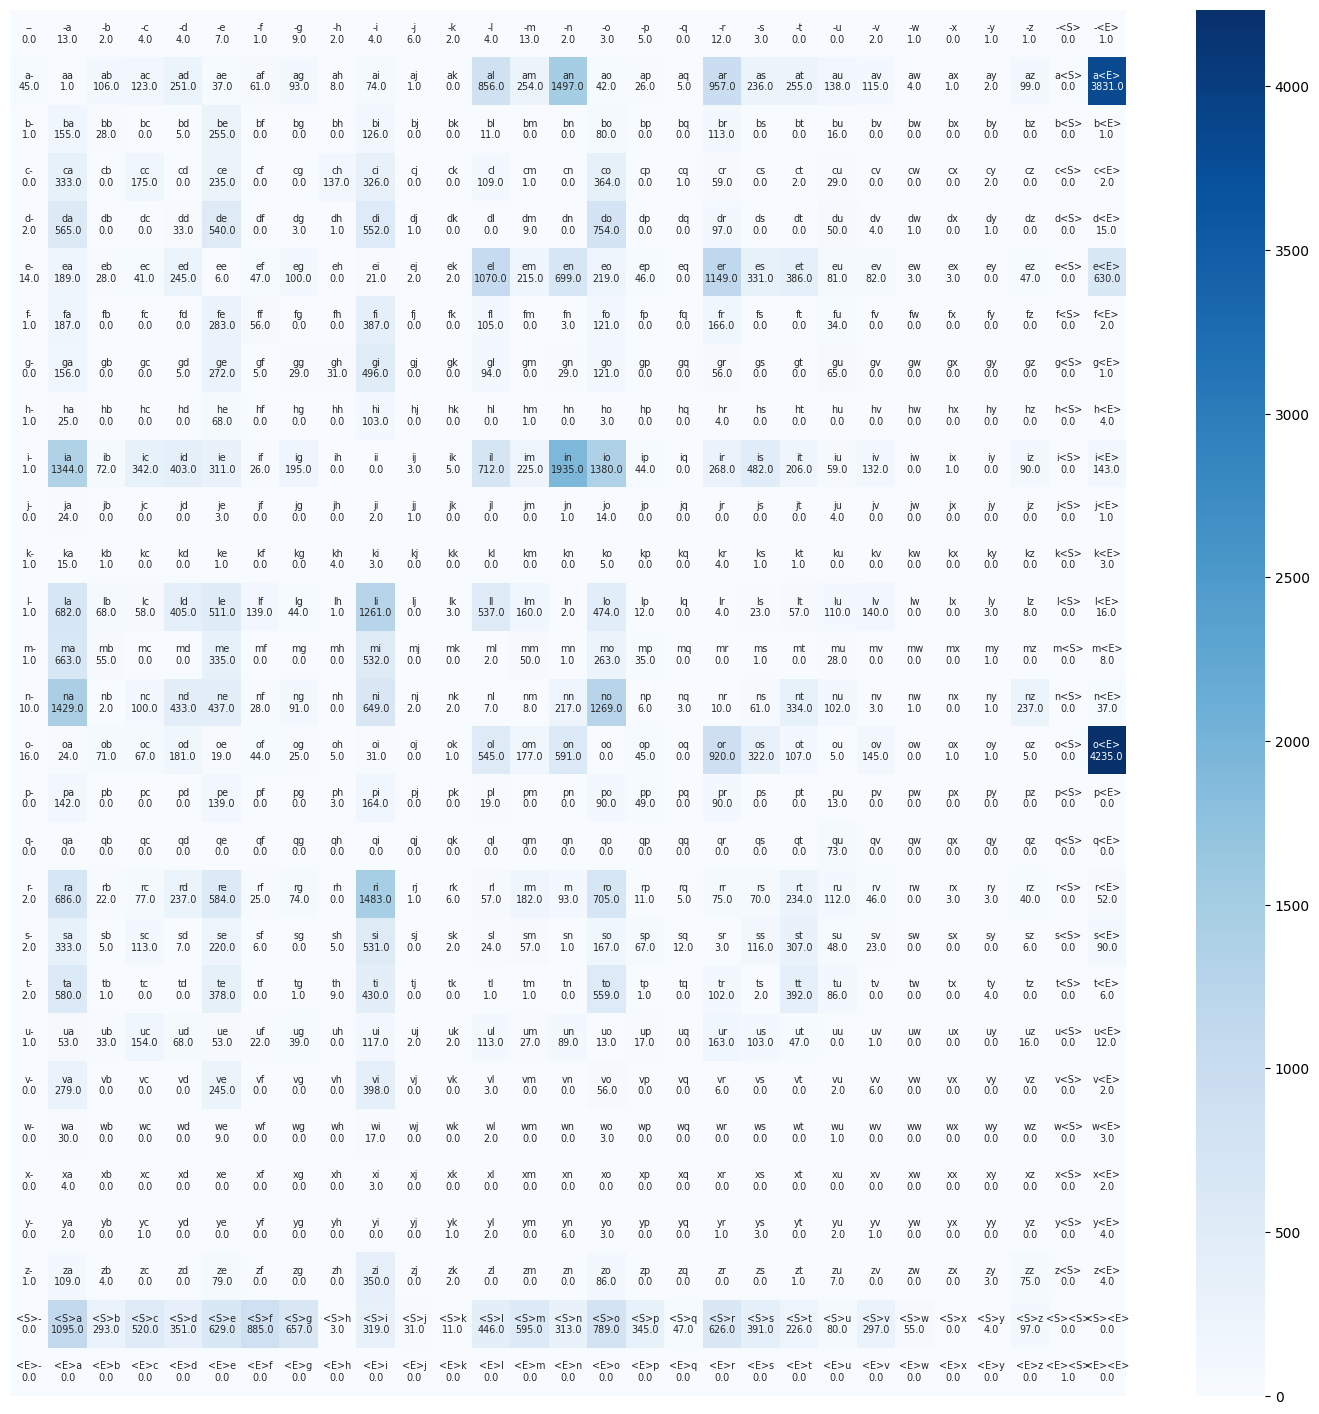

In [40]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(18, 18))
labels = np.array([[itos[i] + itos[j] + '\n' + str(N[i, j].item())
                  for j in range(29)] for i in range(29)])
sns.heatmap(N, xticklabels=False, yticklabels=False, fmt='', cmap='Blues',
            annot=labels, annot_kws={"fontsize": 6.9})  # nice font size

How can we use counting to infer our probability?
How can we reproduce the probability distribution of these numbers?

Let's start by computing the probability of the first character.
First, normalize all the rows of the tensor, then sample using frequencies.
It is possible, with PyTorch, to normalize all the rows of a matrix (stochastic on the row) by doing M/M.sum(...).
Assume that $\vec{p}$ is now our 27th row normalized, i.e. '\<S\>' + '%c' string, which represents the frequency of starting letters.
Using the conditional probability known by the dataset one can start to generate words basing on bigrams, actually in a Markov chain approximation.
However, the result is not properly good (is very, very bad ngl).
Words must be extracted with repetition from our $\vec{p}$ vector.
Actually, an integer is generated, not a word.

**TRIVIA** ChatGPT has a vocabulary of words (chunks - word pieces), not characters.

In [41]:
p = N / N.sum(axis=1, keepdims=True)
g = torch.Generator().manual_seed(123450)

for i in range(10):
    out = []
    ix = 27
    while True:
        pix = p[ix]
        ix = torch.multinomial(
            pix, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 28:
            break
    print(''.join(out))

epucia<E>
o<E>
lgomenzano<E>
a<E>
ginttio<E>
s<E>
ciniglclalirermo<E>
feonedo<E>
mola<E>
ndo<E>


What if the probability distribution was uniform?

In [42]:
for i in range(10):
    out = []
    ix = 27
    while True:
        pix = torch.ones(29)/29.0
        ix = torch.multinomial(
            pix, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 28:
            break
    print(''.join(out))

aaognqusx<E>
sx<S>ukksqzwca<S><E>
zvksvkbglkndtjxwfra<S>fotxorg<S>x<S>mytxlnvdrqordxkclczhn-ynrqjp-l<E>
xwcsruntl-rdkfbzexahxcxoxa-ucfnoae<E>
natlmee<S>yxjtpynrn-zsps<E>
zmpaaxp<E>
cidlwhsmmllkndpzawmdxkhnnyghb<E>
cchgmhzv<S>lf<S>sfwrwwolpb<S>-itrmv-j-lld<S>gouh<E>
mmuykixwsdddbaopvxqldjwwy<S>my-trkjwbjdoqkkxepmw<S>cjv<E>
lzyywd<S>kwu<E>


Words generated with uniform distribution are way worse, so just using the probability of the dataset (simple information - just counting) one can achieve a quite good result with respect to the total randomness.

How to evaluate an algorithm like this one? (just one char memory)
How can we do better?